#Set-Up

In [45]:
#Copy-and-paste the code below to use as "set-up" when your optimization model uses Pyomo and Coin-OR solvers.
#for reference, see https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers

%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

from pyomo.environ import *

#Balancing the Clock: Smarter Overtime Allocation for Cost Efficient Productivity

In [64]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, NonNegativeReals, SolverFactory, minimize
import pandas as pd
import random

# Initialize the model
model = ConcreteModel()

# Simulated Data
employees = list(range(1, 11))  # 10 employees

# Define maximum overtime for each employee, with two having 0 overtime hours
max_overtime = {
    1: 15,   # Employee 1 can work a maximum of 15 overtime hours
    2: 12,   # Employee 2 can work a maximum of 12 overtime hours
    3: 20,   # Employee 3 can work a maximum of 20 overtime hours
    4: 18,   # Employee 4 can work a maximum of 18 overtime hours
    5: 14,   # Employee 5 can work a maximum of 14 overtime hours
    6: 10,   # Employee 6 can work a maximum of 16 overtime hours
    7: 0,    # Employee 7 cannot work any overtime
    8: 8,    # Employee 8 can work a maximum of 8 overtime hours
    9: 20,   # Employee 9 can work a maximum of 20 overtime hours
    10: 0    # Employee 10 cannot work any overtime
}

total_overtime_cap = 200  # Total overtime hours cap for all employees
overtime_budget = 5000  # Overtime budget cap

base_salaries = {  # Base hourly salaries for each employee
    1: 20, 2: 22, 3: 25, 4: 18, 5: 21,
    6: 23, 7: 20, 8: 19, 9: 24, 10: 26
}

# Calculate overtime wages (1.5x base salary)
overtime_wages = {i: base_salaries[i] * 1.5 for i in employees}

# Base hours: each employee works 80 hours by default
base_hours = 40

# Set the productivity targets for each employee (these can vary per employee)
productivity_targets = {
    1: 10, 2: 8, 3: 12, 4: 9, 5: 11,
    6: 14, 7: 8, 8: 7, 9: 13, 10: 10
}

# Minimum productivity required regardless of overtime
base_productivity = {
    1: 8, 2: 7, 3: 9, 4: 7, 5: 9,
    6: 10, 7: 6, 8: 6, 9: 9, 10: 8
}

# Initialize overtime hours decision variables
model.x = Var(employees, domain=NonNegativeReals)

# Define objective function to minimize overtime costs
model.obj = Objective(
    expr=sum(overtime_wages[i] * model.x[i] for i in employees),
    sense=minimize
)

# Total overtime constraint
model.total_overtime = Constraint(expr=sum(model.x[i] for i in employees) <= total_overtime_cap)

# Budget constraint
model.budget_constraint = Constraint(expr=sum(overtime_wages[i] * model.x[i] for i in employees) <= overtime_budget)

# Add a productivity constraint to ensure each employee meets their minimum productivity level
for i in employees:
    model.add_component(f"prod_constraint_{i}", Constraint(
        expr=(productivity_targets[i] * model.x[i]) >= base_productivity[i] * base_hours
    ))

# Calculate the productivity gaps for each employee (in terms of base hours)
remaining_productivity_gap = {
    i: (productivity_targets[i] - base_productivity[i]) * base_hours
    for i in employees
}

# Calculate the total remaining productivity gap
total_productivity_gap = sum(remaining_productivity_gap[i] for i in employees)

# Distribute overtime hours based on the remaining productivity gap
for i in employees:
    if remaining_productivity_gap[i] > 0:
        # Calculate the proportion of the total gap each employee accounts for
        proportion_of_gap = remaining_productivity_gap[i] / total_productivity_gap
        # Allocate overtime hours proportionally based on the gap
        overtime_hours_allocated = proportion_of_gap * total_overtime_cap
        model.x[i] = min(overtime_hours_allocated, max_overtime[i])  # Cap by the max overtime allowed
    else:
        model.x[i] = 0  # No overtime needed if no productivity gap

# Solve the model
solver = SolverFactory('cbc')
solver.solve(model, tee=True)

# Extract and display results
results = {
    "Employee": [],
    "Overtime Hours": [],
    "Overtime Wage ($/hour)": [],
    "Cost ($)": [],
    "Production (Tasks)": [],
    "Base Salary ($/hour)": [],
    "Total Hours Worked": []  # New field to display total hours (base + overtime)
}

total_cost = 0
total_production = 0

for i in employees:
    overtime_hours = model.x[i].value
    cost = overtime_hours * overtime_wages[i]
    production = productivity_targets[i] * overtime_hours
    total_hours = base_hours + overtime_hours  # Total hours = base hours + overtime
    results["Employee"].append(i)
    results["Overtime Hours"].append(round(overtime_hours, 2))
    results["Overtime Wage ($/hour)"].append(overtime_wages[i])
    results["Cost ($)"].append(round(cost, 2))
    results["Production (Tasks)"].append(round(production, 2))
    results["Base Salary ($/hour)"].append(base_salaries[i])
    results["Total Hours Worked"].append(total_hours)
    total_cost += cost
    total_production += production

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)
print(f"Total Overtime Cost: ${total_cost:.2f}")
print(f"Total Production Achieved: {total_production} tasks")


Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Jun  7 2023 

command line - /content/bin/cbc -printingOptions all -import /tmp/tmpfqtwz08b.pyomo.lp -stat=1 -solve -solu /tmp/tmpfqtwz08b.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve determined that the problem was infeasible with tolerance of 1e-08
Presolved model looks infeasible - will use unpresolved


Problem has 12 rows, 10 columns (10 with objective) and 30 elements
Column breakdown:
10 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
10 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
2 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type Free 
Presolve determined that the problem was infeasible with t

  - termination condition: infeasible
  - message from solver: <undefined>


   Employee  Overtime Hours  Overtime Wage ($/hour)  Cost ($)  \
0         1           15.00                    30.0    450.00   
1         2            8.70                    33.0    286.96   
2         3           20.00                    37.5    750.00   
3         4           17.39                    27.0    469.57   
4         5           14.00                    31.5    441.00   
5         6           10.00                    34.5    345.00   
6         7            0.00                    30.0      0.00   
7         8            8.00                    28.5    228.00   
8         9           20.00                    36.0    720.00   
9        10            0.00                    39.0      0.00   

   Production (Tasks)  Base Salary ($/hour)  Total Hours Worked  
0              150.00                    20           55.000000  
1               69.57                    22           48.695652  
2              240.00                    25           60.000000  
3              156.5

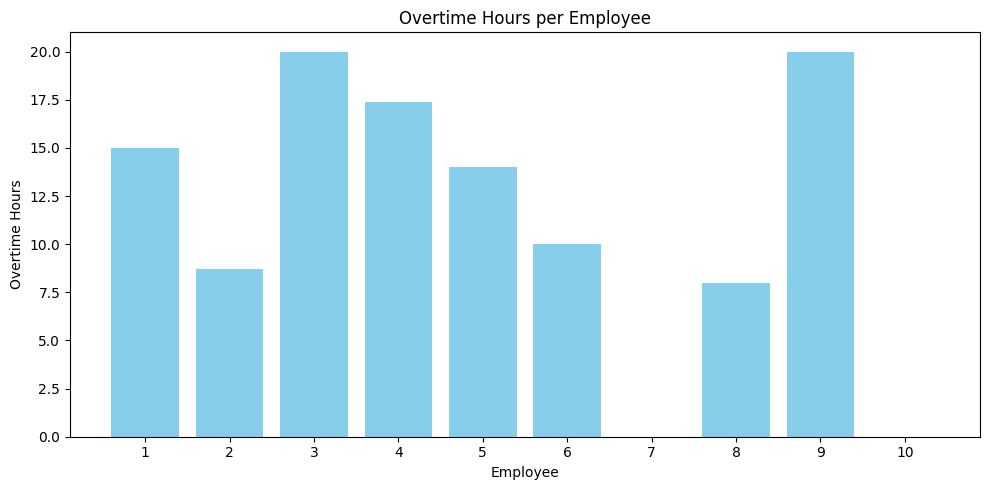

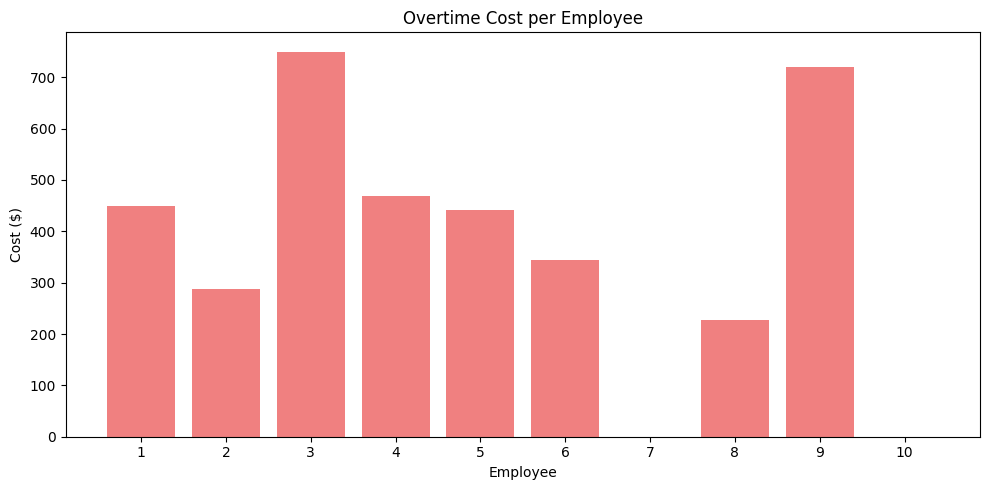

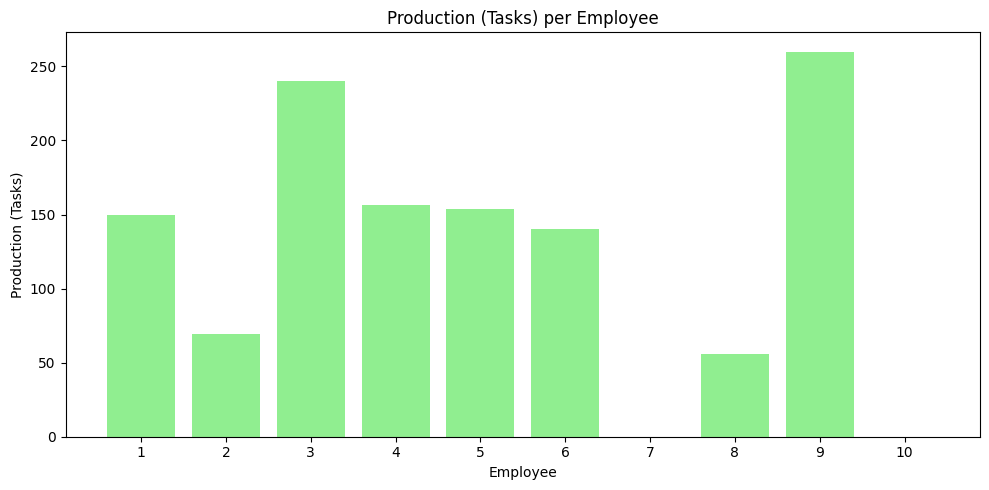

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from your output
data = {
    "Employee": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "Overtime Hours": [15, 8.7, 20, 17.39, 14, 10, 0, 8, 20, 0],
    "Cost ($)": [450, 286.96, 750, 469.57, 441, 345, 0, 228, 720, 0],
    "Production (Tasks)": [150, 69.57, 240, 156.52, 154, 140, 0, 56, 260, 0],
}

df = pd.DataFrame(data)

# Plot 1: Overtime Hours per Employee
plt.figure(figsize=(10, 5))
plt.bar(df["Employee"], df["Overtime Hours"], color="skyblue")
plt.title("Overtime Hours per Employee")
plt.xlabel("Employee")
plt.ylabel("Overtime Hours")
plt.xticks(df["Employee"])
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot 2: Overtime Cost per Employee
plt.figure(figsize=(10, 5))
plt.bar(df["Employee"], df["Cost ($)"], color="lightcoral")
plt.title("Overtime Cost per Employee")
plt.xlabel("Employee")
plt.ylabel("Cost ($)")
plt.xticks(df["Employee"])
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot 3: Production Tasks per Employee
plt.figure(figsize=(10, 5))
plt.bar(df["Employee"], df["Production (Tasks)"], color="lightgreen")
plt.title("Production (Tasks) per Employee")
plt.xlabel("Employee")
plt.ylabel("Production (Tasks)")
plt.xticks(df["Employee"])
plt.grid(False)
plt.tight_layout()
plt.show()


